Things I can do :
- Use inner functions for preprocessing (since i wont use seg norma reflect ... in other places, I create them as inner functions)
- we can use data augmentation if data is not sufficient and SMOTE to solve the problem of unbalanced data


In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.0 MB/s eta 0:00:00


In [ ]:
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.filters import threshold_multiotsu
import cv2 
import numpy as np
from sklearn.model_selection import train_test_split
import csv


from math import sqrt

import tensorflow as tf
import tensorflow_addons as tfa

import os
from google.colab import drive
drive.mount('/content/drive')

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Mounted at /content/drive
Number of replicas: 1
2.12.0


In [ ]:
# Segmentation 
def mask (image, Fcint, Fcext, cxe, cye, cxi, cyi):
    nl= image.shape[0]
    nc=  image.shape[1]
    xe = np.arange(-cxe[0],nc-cxe[0],1)
    ye = np.arange(-cye[0],nl-cye[0],1)
    xxe, yye = np.meshgrid(xe, ye, sparse=True)
    ze = np.sqrt(xxe*xxe + yye*yye)
    xi = np.arange(-cxi[0],nc-cxi[0],1)
    yi = np.arange(-cyi[0],nl-cyi[0],1)
    xxi, yyi = np.meshgrid(xi, yi, sparse=True)
    zi = np.sqrt(xxi*xxi + yyi*yyi)
    
    return (ze<Fcext)*(Fcint<zi)

def seg (img) :   
# Thresholding and edge detection
    filterSize =(5, 5)
    kernel = np.ones((5, 5), np.uint8)
    image = cv2.erode(img,kernel)     # bch naho holes li capable yjo fla pupille or at least ne9sohom  (testit b image ta3 taha ta3 dataset AMF)

# for inner boundary
    ret1,th1 = cv2.threshold(image,30,255,cv2.THRESH_BINARY)
    edgesint= canny(th1, sigma=3, low_threshold=30, high_threshold=255)

# calculate hough radius
    hough_radiii = np.arange(30, 60)
    hough_resi = hough_circle(edgesint, hough_radiii)
    accumsi, cxi, cyi, radiii = hough_circle_peaks(hough_resi, hough_radiii,total_num_peaks=1)


# for outer boundary
    hough_radiie = np.arange(70, 2000)
    ret2,th2 = cv2.threshold(image,110,255,cv2.THRESH_BINARY)
    edgesext= canny(th2, sigma=3, low_threshold=110, high_threshold=255)

    hough_rese = hough_circle(edgesext, hough_radiie)
    if (hough_rese.sum() != 0) :
        accumse, cxe, cye, radiie = hough_circle_peaks(hough_rese, hough_radiie,total_num_peaks=1)
        d= sqrt((cxe-cxi)^2 + (cye-cyi)^2)
        if (d>10) :
          thresholds = threshold_multiotsu(image)
          regions = np.array(np.digitize(image, bins=thresholds), np.uint8)
          sobelx = cv2.Sobel(src=regions,ddepth=cv2.CV_8UC1,  dx=1, dy=0, ksize=5)
          sobely = cv2.Sobel(src=regions,ddepth=cv2.CV_8UC1, dx=0, dy=1, ksize=5) 
          sobelxy = cv2.Sobel(src=regions,ddepth=cv2.CV_8UC1, dx=1, dy=1, ksize=5)
          edgesext = cv2.dilate(sobelxy, kernel)
          accumse, cxe, cye, radiie = hough_circle_peaks(hough_rese, hough_radiie,total_num_peaks=1)

    if ( len(cxi)!= 0 ) and (len(cxe)!= 0) and ( len(cyi)!= 0 ) and (len(cye)!= 0) and (radiii[0]!= 0) and (radiie[0]!= 0) :
        Seg = (image) * mask (image, radiii, radiie, cxe, cye, cxi, cyi)
        return Seg, cxi[0],cyi[0], radiii[0], radiie[0]
    
    else : return [], None, None,None, None

In [ ]:
# Reflections 
def reflect(gray):
    # reflections' localizing and enhancement  
    ret1,th1 = cv2.threshold(gray,200,255,cv2.THRESH_BINARY)
    refpart = gray*(th1//255)
    refpart  = refpart.astype('uint8')
    ref_HE= cv2.equalizeHist(refpart)
    
    # image totally enhaced 
    img_enh_f = gray - th1 + ref_HE

    for i in range(img_enh_f.shape[0]):
      for j in range(img_enh_f.shape[1]):
        img_enh_f[i][j]= max(0,img_enh_f[i][j])  # didnt find relu function in openCV


    return img_enh_f 

In [ ]:
# Normalisation
def norm (image, cxi,cyi, radiii, radiie):
    if (cxi != None) & (cyi != None) & (radiii != None) & (radiie != None):
      theta = np.arange(0, 360, 1) #theta
      rad = np.arange(0, (radiie-radiii), 1) #radius
      
      normal = np.empty(shape = [rad.size, theta.size])
      
      for t in theta:
          for r in rad:
              polarX = int(((r+radiii) * np.cos(t*3.14/180)) + cxi)
              polarY = int(((r+radiii) * np.sin(t*3.14/180)) + cyi)
              if (polarX < image.shape[1]) and (polarY < image.shape[0]):
                  normal[int(r)][int(t) - 1] = image[polarY][polarX]
              else : 
                  normal[int(r)][int(t) - 1] = 0
      return normal
    else : return []

In [ ]:
# Enhacement
def gammaCorrection(img, gamma):
    table = np.array([((i / 255) ** (gamma)) * 255 for i in range(256)])
    return cv2.LUT(img, table)

def gamma (grayimg):     
    hist, bins = np.histogram(grayimg , bins= np.arange(0,256)) 
    if(len(hist)!=len(bins)):
        hist = np.append(hist, 0 )
    index = np.where(hist == max(hist))[0][0]
    if (index>160):
        return 0.9
    else :
        if (index < 60): 
            return 1.1
        else : return 1   
    
def enh(gray) :
    # enhacement of the image
    gray = gray.astype(np.uint8)
    hist = cv2.equalizeHist(gray)
    med= cv2.medianBlur(hist,3)
    GIC = gammaCorrection(med,gamma(gray))
    filterSize =(3, 3)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, filterSize)  
    img1 = gray - cv2.morphologyEx(GIC, cv2.MORPH_BLACKHAT,kernel) - cv2.morphologyEx(GIC, cv2.MORPH_TOPHAT,kernel) 
    return img1

In [ ]:
# Preprocessing 
def prepro (image, name, L1, L2):    
    segm,cxi,cyi, radiii, radiie = seg(image)
    if len(segm) != 0 :
        ref = reflect(segm)
        normal = norm(ref,cxi,cyi, radiii, radiie)
        if (normal.shape[0]>0):
          enhc = enh(normal)
          return enhc
        else : 
          L1.append(name)
          return []
    else : 
        L2.append(name)
        return []

In [ ]:
# data cleaning 
def data_clean (x,y,writer,path, image, label, L):   # writer is a csv writer
  booll= (image<10)
  if not((booll.sum()/(image.shape[0]*image.shape[1]))>0.75):
    writer.writerow([path, label]) 
    x.append(image)
    y.append(label)
  else :
    L.append(0)

In [ ]:
fait=[]
for root, dir, images in os.walk('/content/drive/MyDrive/PFE/AMFseg'):
  for image in images :
    if image.startswith('zak') :
      fait.append(image[10:])
    else : 
      if image.startswith('wis') or image.startswith('zaf') :
        fait.append(image[8:])
print(len(fait))
print(fait)

25
['Iris_20220818_122627_Right.bmp', 'Iris_20220818_122420_Left.bmp', 'Iris_20220818_122627_Left.bmp', 'Iris_20220818_122630_Right.bmp', 'Iris_20220818_111219_Left.bmp', 'Iris_20220818_111226_Left.bmp', 'Iris_20220818_111226_Right.bmp', 'Iris_20220818_111212_Left.bmp', 'Iris_20220818_111210_Left.bmp', 'Iris_20220818_122656_Right.bmp', 'Iris_20220818_122702_Right.bmp', 'Iris_20220818_122702_Left.bmp', 'Iris_20220818_122700_Right.bmp', 'Iris_20220818_122700_Left.bmp', 'Iris_20220818_122630_Left.bmp', 'Iris_20220818_122656_Left.bmp', 'Iris_20220818_111216_Left.bmp', 'Iris_20220818_111212_Right.bmp', 'Iris_20220818_111210_Right.bmp', 'Iris_20220818_111216_Right.bmp', 'Iris_20220818_111219_Right.bmp', 'Iris_20220818_122413_Left.bmp', 'Iris_20220818_122413_Right.bmp', 'Iris_20220818_122405_Right.bmp', 'Iris_20220818_122420_Right.bmp']


In [ ]:
# creating dataset
labels=[]
label_id={}

x=[]
y=[]

normprob = []
segprob = []
datacleaned = []


newpath = '/content/drive/MyDrive/PFE/AMFseg'
with open('/content/drive/MyDrive/PFE/AMFseg.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for root, dir, images in os.walk('/content/drive/MyDrive/PFE/AMF'):
        for img in images:
            if (img.endswith('jpg')) or (img.endswith('bmp')) and (not(img in fait)) :       
                path= os.path.join(root, img)
                label = os.path.basename(os.path.dirname(path))
                    
                if not (label in labels) :
                    labels.append(label)
                    label_id [label] = len(labels)-1

                imag = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                imag = prepro(imag, img, normprob, segprob)

                if len(imag) != 0 :
                  cv2.imwrite(f'{newpath}/{label}___{img}', imag)
                  # LL  = pywt.dwt2(img, 'bior2.2' )
                  imag= cv2.resize(imag, (360,100) , interpolation = cv2.INTER_AREA)
                  data_clean(x,y,writer,path, imag , label_id[label], datacleaned)
                  print(f'image {img} is done')
                  fait.append(im)
x= np.array(x)
y= np.array(y)

ValueError: ignored

In [ ]:
print(y.shape)  # means 19 images t7acho ca va
print(x[0].shape)

(435,)
(128, 128)


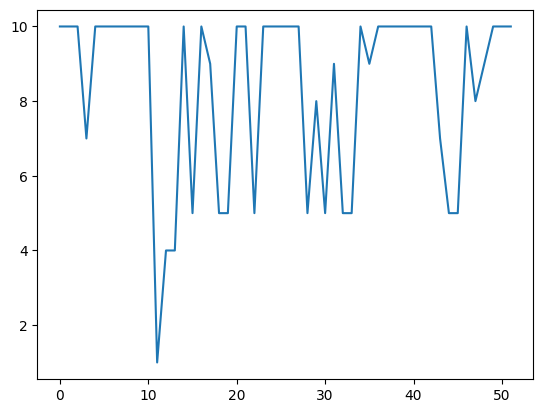

In [ ]:
from skimage import exposure
import matplotlib.pyplot as plt

hist = exposure.histogram(y)    # pour voir wila balanced dataset wla lala
plt.plot(hist[0])

In [ ]:
# Dividing the data set into train and test and training the model
xtr, xts, ytr, yts = train_test_split(x,y, test_size=0.2)

# divide train into train w validation mzl madertha ...

In [ ]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),   
           tfa.metrics.F1Score(num_classes=52)]     # 52 ta3 AMF
EPOCHS = 10

In [ ]:
# dynamic learning rate
def exponential_decay(lr0, s):     # i need to search what is s and wch kayen type of learning rate schedulers.
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)

In [ ]:
CNN = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128,128,1)),
    tf.keras.layers.Conv2D(96, (11,11), strides = (4,4), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.ZeroPadding2D(padding= (2,2)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.ZeroPadding2D(padding= (1,1)),
    tf.keras.layers.Conv2D(8, (5, 5), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(52, activation='softmax')
                             ])
with strategy.scope():   # 3la l tpu in case kayen
  CNN.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=METRICS
      )

CNN.summary()
    
# networkX python library for graphs theory 

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 30, 30, 96)        11712     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 15, 15, 96)       0         
 g2D)                                                            
                                                                 
 zero_padding2d_24 (ZeroPadd  (None, 19, 19, 96)       0         
 ing2D)                                                          
                                                                 
 conv2d_37 (Conv2D)          (None, 17, 17, 16)        13840     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                     

In [ ]:
# CNN training
history = CNN.fit(
    xtr,ytr,
    # validation_data=xval,    xval necreyiha apres
    callbacks=[lr_scheduler, my_callback],
    epochs=EPOCHS
)


Epoch 1/20
11/11 [==============================] - 7s 456ms/step - loss: 4.7554 - accuracy: 0.0259
Epoch 2/20
11/11 [==============================] - 3s 294ms/step - loss: 3.8432 - accuracy: 0.0632
Epoch 3/20
11/11 [==============================] - 3s 287ms/step - loss: 3.6415 - accuracy: 0.0977
Epoch 4/20
11/11 [==============================] - 3s 312ms/step - loss: 3.2159 - accuracy: 0.1810
Epoch 5/20
11/11 [==============================] - 5s 449ms/step - loss: 2.7488 - accuracy: 0.2529
Epoch 6/20
11/11 [==============================] - 3s 292ms/step - loss: 2.4078 - accuracy: 0.3247
Epoch 7/20
11/11 [==============================] - 3s 280ms/step - loss: 1.9310 - accuracy: 0.4023
Epoch 8/20
11/11 [==============================] - 3s 309ms/step - loss: 1.6202 - accuracy: 0.5172
Epoch 9/20
11/11 [==============================] - 5s 442ms/step - loss: 1.3365 - accuracy: 0.6006
Epoch 10/20
11/11 [==============================] - 3s 274ms/step - loss: 1.0561 - accuracy: 0.6954

In [ ]:
loss, acc = CNN.evaluate(xts,yts)

3/3 [==============================] - 0s 46ms/step - loss: 3.5785 - accuracy: 0.4483
